# Imports

In [1]:
from models import Model1
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

cuda:0
Files already downloaded and verified
Files already downloaded and verified
[1,    10] loss: 2.304
[1,    20] loss: 2.303
[2,    10] loss: 2.303
[2,    20] loss: 2.303
[3,    10] loss: 2.303
[3,    20] loss: 2.303
[4,    10] loss: 2.303
[4,    20] loss: 2.303
Finished Training


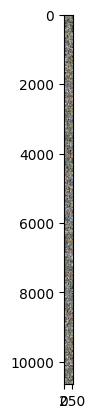

GroundTruth:  cat   ship  ship  plane
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 100.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


In [2]:
PATH ='./cifarmodel1.pth'

device = torch.device('cuda:0')
print(device)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Transformations
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            transforms.RandomErasing(0.2),
                                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

#Creating the Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=test_transforms)

#Data Loaders
batch_size = 2500

trainloader = data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, pin_memory=True)


testloader = data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


model = Model1()

try:
    model.load_state_dict(torch.load(PATH))
except:
    print("File does not exist, unable to load state dictionary from PATH")

model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)

torch.backends.cudnn.benchmark = True

for epoch in range(4):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        for param in model.parameters():
            param.grid = None

        # forward + backward + optimize
        outputs = model(inputs).cuda()
        loss = criterion(outputs, labels)
        loss.cuda()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.3f}')
                running_loss = 0.0

print('Finished Training')
torch.save(model.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images).cuda()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images).cuda()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
PATH ='./cifarmodel2.pth'

device = torch.device('cuda:0')
print(device)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Transformations
train_transforms = transforms.Compose([
                            transforms.GaussianBlur(kernel_size = (3,3)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            transforms.RandomErasing(0.2),
                            transforms.RandomRotation(45),
                            transforms.RandomHorizontalFlip(25),
                            transforms.RandomVerticalFlip(25),
                                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

#Creating the Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=test_transforms)

#Data Loaders
batch_size = 2500

trainloader = data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, pin_memory=True)


testloader = data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


model1 = Model1()

try:
    model.load_state_dict(torch.load(PATH))
except:
    print("File does not exist, unable to load state dictionary from PATH")

model1.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.backends.cudnn.benchmark = True

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        for param in model.parameters():
            param.grid = None

        # forward + backward + optimize
        outputs = model(inputs).cuda()
        loss = criterion(outputs, labels)
        loss.cuda()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.3f}')
                running_loss = 0.0

print('Finished Training')
torch.save(model.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = next(dataiter)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images).cuda()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images).cuda()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

cuda:0
Files already downloaded and verified
Files already downloaded and verified
File does not exist, unable to load state dictionary from PATH
[1,    10] loss: 2.304
[1,    20] loss: 2.305
[2,    10] loss: 2.302
[2,    20] loss: 2.303
[3,    10] loss: 2.297
[3,    20] loss: 2.268
[4,    10] loss: 2.438
[4,    20] loss: 2.370
[5,    10] loss: 2.317
[5,    20] loss: 2.314
